In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.seasonal import STL
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator, awesome_oscillator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
import warnings
warnings.filterwarnings('ignore')

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'


Bad key "text.kerning_factor" on line 4 in
C:\Users\Pranav\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def plot_ohlc(df):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Ohlc(x=df.index,
                          open=df.Open,
                          high=df.High,
                          low=df.Low,
                          close=df.Close,
                          name='Price'), row=1, col=1)

    fig.add_trace(go.Scatter(x=df.index, y=df.Volume, name='Volume'), row=2, col=1)

    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()

def plot_decomposed_close_data(df):
    data = azn_df[['Close']].copy()
    res = STL(data, period=365).fit()
    fig = res.plot()
    fig.set_size_inches(20, 8)
    
def plot_moving_averages(df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df.EMA_9, name='EMA 9'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_5, name='SMA 5'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_10, name='SMA 10'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_15, name='SMA 15'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_30, name='SMA 30'))
    fig.add_trace(go.Scatter(x=df.index, y=df.Close, name='Close', opacity=0.2))
    fig.show()
    
def plot_RSI(df):
    fig = go.Figure(go.Scatter(x=df.index, y=df.RSI, name='RSI'))
    fig.show()
    
def plot_MACD(df):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.index, y=df['MACD'], name='MACD'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df['MACD Signal'], name='Signal line'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df.Close, name='Close'), row=2, col=1)
    fig.show()
    
def plot_train_test_data(train_df, valid_df, test_df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
    fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
    fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
    fig.show()
    
def plot_predictions(predicted_prices, df, column):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.index, y=df[column],
                             name='Truth',
                             marker_color='LightSkyBlue'), row=1, col=1)

    fig.add_trace(go.Scatter(x=predicted_prices.index,
                             y=predicted_prices[column],
                             name='Prediction',
                             marker_color='MediumPurple'), row=1, col=1)

    fig.show()
    
def plot_high_low_predictions(predicted_prices, df):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.index, y=df.High,
                             name='Truth',
                             marker_color='LightSkyBlue'), row=1, col=1)

    fig.add_trace(go.Scatter(x=predicted_prices.index,
                             y=predicted_prices.High,
                             name='Prediction',
                             marker_color='MediumPurple'), row=1, col=1)

    fig.show()
    
def get_moving_averages(df):
    df_sma = SMAIndicator(close=df['Close'], window=5)
    df['SMA_5'] = df_sma.sma_indicator()
    df_sma = SMAIndicator(close=df['Close'], window=10)
    df['SMA_10'] = df_sma.sma_indicator()
    df_sma = SMAIndicator(close=df['Close'], window=15)
    df['SMA_15'] = df_sma.sma_indicator()
    df_sma = SMAIndicator(close=df['Close'], window=30)
    df['SMA_30'] = df_sma.sma_indicator()
    df_ema = EMAIndicator(close=df['Close'], window=9)
    df['EMA_9'] = df_ema.ema_indicator()
    df.dropna(inplace=True)
    
def get_RSI(df):
    df_rsi = RSIIndicator(close=df['Close'], window=14)
    df['RSI'] = df_rsi.rsi()
    df.dropna(inplace=True)
    
def get_MACD(df):
    macd = MACD(close=df['Close'])
    df['MACD'] = macd.macd()
    df['MACD Signal'] = macd.macd_signal()
    df.dropna(inplace=True)

In [3]:
start = dt.datetime(2017,1,1)
end = dt.datetime.now()
tickers = ['PFE', 'MRNA', 'JNJ', 'AZN', 'BTC-USD', 'ETH-USD', 'LTC-USD']

filenames = []

for ticker in tickers:
    if ticker == 'MRNA':
        df = yf.download(ticker, dt.datetime(2018,12,7), end)
    else:
        df = yf.download(ticker, start, end)
    filename = f'{ticker}_stock_prices.csv'
    filenames.append(filename)
    df.to_csv(filename)
    
for filename in filenames:
    if filename.startswith('AZN'):
        azn_df = pd.read_csv('AZN_stock_prices.csv', index_col='Date', parse_dates=True)
    elif filename.startswith('BTC-USD'):
        btc_df = pd.read_csv('BTC-USD_stock_prices.csv', index_col='Date', parse_dates=True)    
    elif filename.startswith('LTC-USD'):
        ltc_df = pd.read_csv('LTC-USD_stock_prices.csv', index_col='Date', parse_dates=True)    
    elif filename.startswith('MRNA'):
        mrna_df = pd.read_csv('MRNA_stock_prices.csv', index_col='Date', parse_dates=True)
    elif filename.startswith('JNJ'):
        jnj_df = pd.read_csv('JNJ_stock_prices.csv', index_col='Date', parse_dates=True)
    else:
        pfe_df = pd.read_csv('PFE_stock_prices.csv', index_col='Date', parse_dates=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
ltc_df.head()

Open     High      Low    Close  Adj Close    Volume
Date                                                               
2017-01-01  4.32912  4.52153  4.32871  4.51159    4.51159  11337500
2017-01-02  4.52045  4.73766  4.48466  4.64894    4.64894  14595300
2017-01-03  4.65588  4.73184  4.56487  4.62620    4.62620  10055700
2017-01-04  4.63375  4.83785  4.63375  4.83785    4.83785  13762400
2017-01-05  4.91437  4.94586  4.22687  4.29272    4.29272  19196000

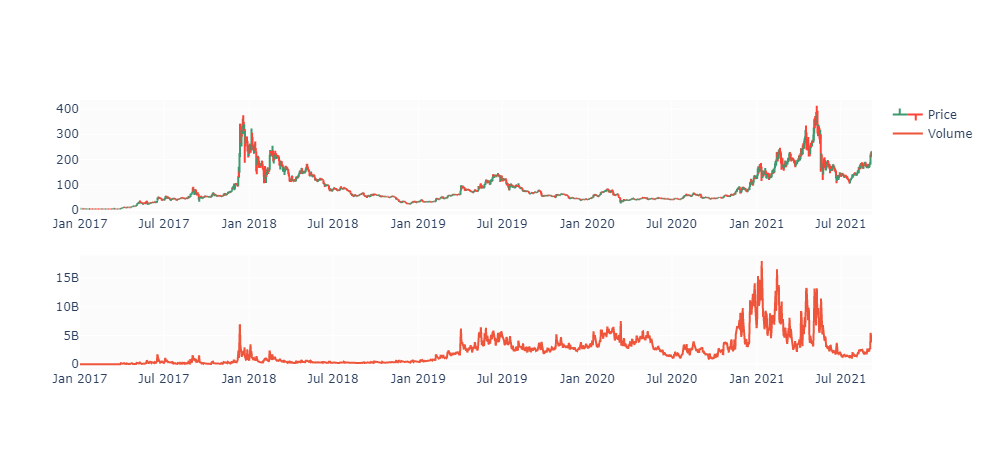

In [5]:
# Get OHLC chart for LTC Litecoin

plot_ohlc(ltc_df)

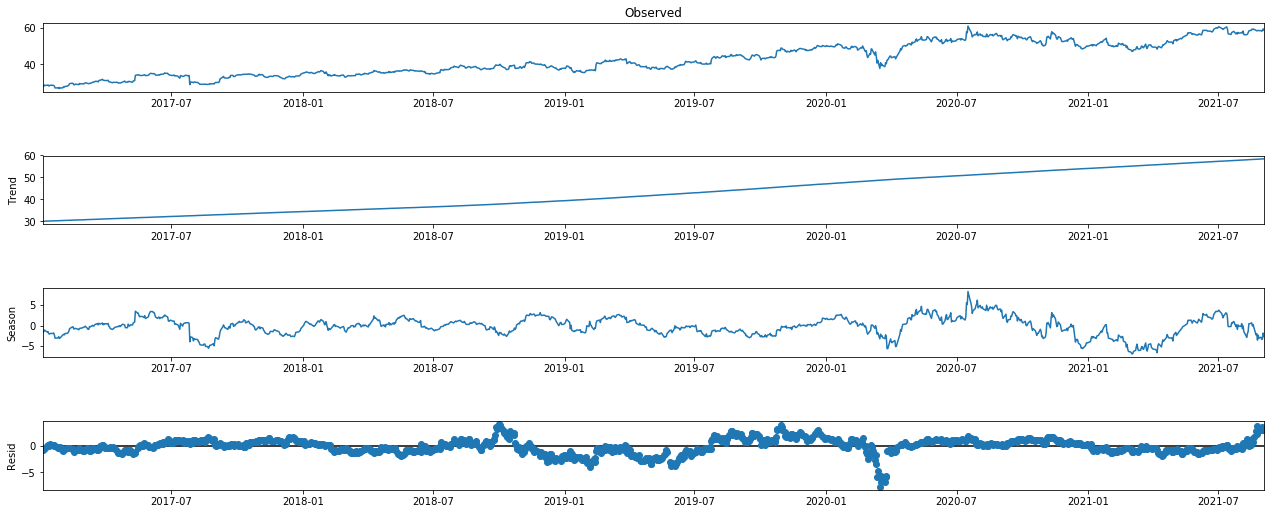

In [6]:
# Decomposing close price for LTC

plot_decomposed_close_data(ltc_df)

In [7]:
get_moving_averages(ltc_df)
ltc_df.head()

Open     High      Low    Close  Adj Close    Volume     SMA_5  \
Date                                                                            
2017-01-30  3.85623  4.02125  3.85596  4.02125    4.02125  10192700  3.883300   
2017-01-31  4.01650  4.10098  4.01650  4.07864    4.07864  15799800  3.932164   
2017-02-01  4.07604  4.13166  4.03058  4.07533    4.07533   7753930  3.976054   
2017-02-02  4.07515  4.09093  4.01694  4.08527    4.08527   5175450  4.022518   
2017-02-03  4.08163  4.10735  4.04019  4.08256    4.08256   8548470  4.068610   

              SMA_10    SMA_15    SMA_30     EMA_9  
Date                                                
2017-01-30  3.850034  3.862050  4.036002  3.881934  
2017-01-31  3.867447  3.873790  4.021571  3.921275  
2017-02-01  3.890686  3.882875  4.002450  3.952086  
2017-02-02  3.915637  3.899347  3.984419  3.978723  
2017-02-03  3.945283  3.914143  3.959243  3.999490

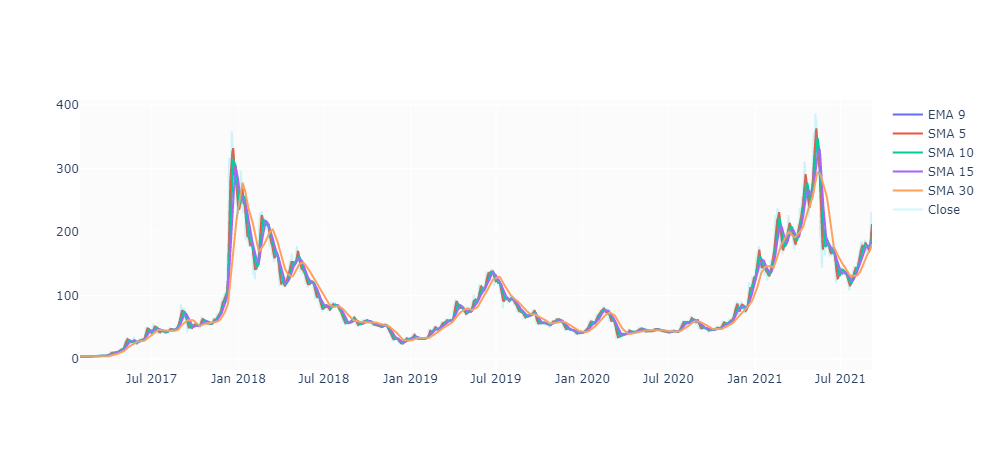

In [8]:
# Plotting Moving Averages for LTC

plot_moving_averages(ltc_df)

In [9]:
get_RSI(ltc_df)
ltc_df.head()

Open     High      Low    Close  Adj Close   Volume     SMA_5  \
Date                                                                           
2017-02-12  3.79587  3.79587  3.74592  3.76437    3.76437  2706320  3.831288   
2017-02-13  3.76823  3.76948  3.70399  3.71789    3.71789  4721650  3.770232   
2017-02-14  3.71529  3.77326  3.70713  3.77080    3.77080  3994400  3.764674   
2017-02-15  3.76918  3.81628  3.75560  3.80928    3.80928  2683590  3.771088   
2017-02-16  3.79676  3.81978  3.77973  3.78681    3.78681  3991580  3.769830   

              SMA_10    SMA_15    SMA_30     EMA_9        RSI  
Date                                                           
2017-02-12  3.942430  3.969126  3.914022  3.881158  14.054953  
2017-02-13  3.905963  3.960179  3.907934  3.848504  12.108909  
2017-02-14  3.877243  3.943482  3.902766  3.832963  24.862631  
2017-02-15  3.853879  3.925525  3.899657  3.828227  32.530562  
2017-02-16  3.828159  3.906290  3.894583  3.819943  30.568762

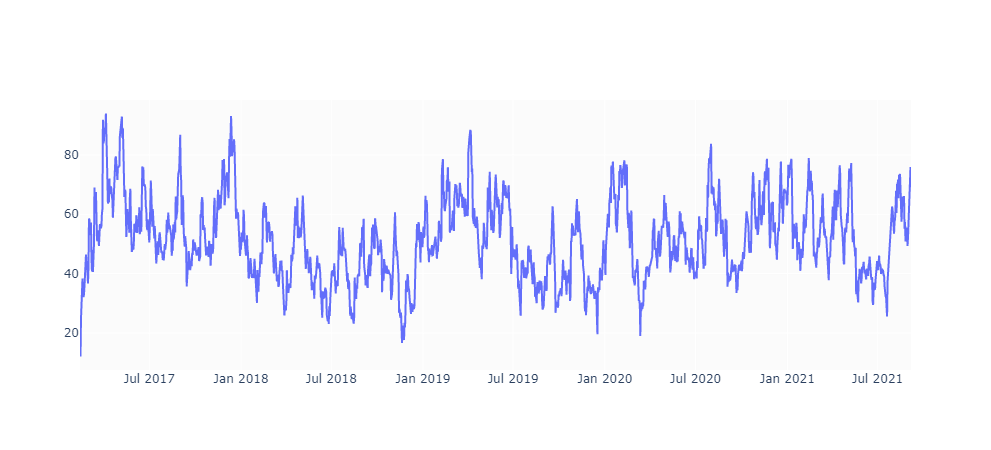

In [10]:
# Plotting RSI 

plot_RSI(ltc_df)

In [11]:
get_MACD(ltc_df)
ltc_df.head()

Open     High      Low    Close  Adj Close    Volume     SMA_5  \
Date                                                                            
2017-03-17  4.23317  4.23317  4.03685  4.05510    4.05510  11109600  4.135760   
2017-03-18  4.04052  4.15746  3.86067  3.96762    3.96762  12199700  4.095176   
2017-03-19  3.95650  4.02711  3.89985  3.95641    3.95641   6013050  4.075420   
2017-03-20  3.95048  4.04542  3.88995  4.03331    4.03331   4068240  4.049908   
2017-03-21  4.03637  4.04106  3.98193  4.00922    4.00922   4970080  4.004332   

              SMA_10    SMA_15    SMA_30     EMA_9        RSI      MACD  \
Date                                                                      
2017-03-17  3.968596  3.942348  3.876707  4.031902  56.020430  0.079888   
2017-03-18  3.987758  3.945468  3.882734  4.019045  51.496133  0.071335   
2017-03-19  3.999557  3.950295  3.886935  4.006518  50.928529  0.062926   
2017-03-20  4.027671  3.959079  3.895011  4.011877  54.623482  0.061756   
2017-03-21  4.048793  3.964933  3.903243  4.011345  53.270298  0.058213   

            MACD Signal  
Date                     
2017-03-17     0.048298  
2017-03-18     0.052905  
2017-03-19     0.054909  
2017-03-20     0.056279  
2017-03-21     0.056665

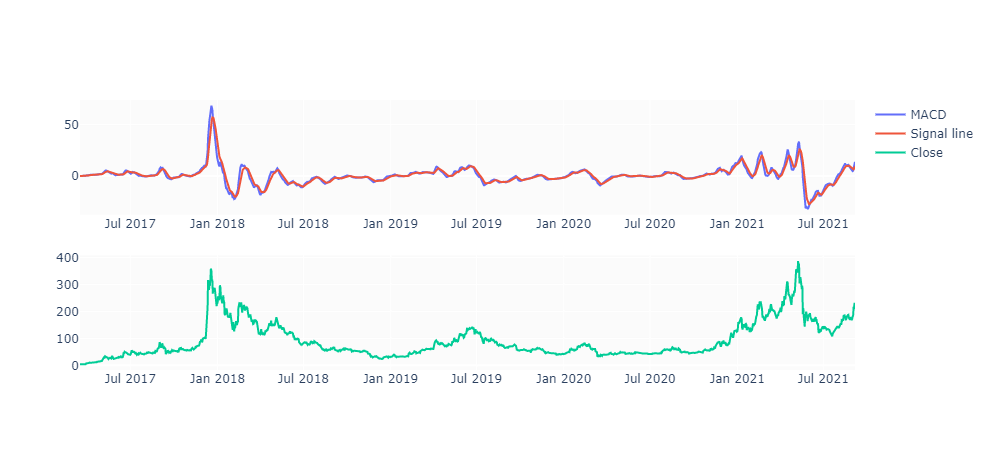

In [12]:
# Plottig MACD

plot_MACD(ltc_df)

In [13]:
ltc_df['Close'] = ltc_df['Close'].shift(-1)
ltc_df.head()

Open     High      Low    Close  Adj Close    Volume     SMA_5  \
Date                                                                            
2017-03-17  4.23317  4.23317  4.03685  3.96762    4.05510  11109600  4.135760   
2017-03-18  4.04052  4.15746  3.86067  3.95641    3.96762  12199700  4.095176   
2017-03-19  3.95650  4.02711  3.89985  4.03331    3.95641   6013050  4.075420   
2017-03-20  3.95048  4.04542  3.88995  4.00922    4.03331   4068240  4.049908   
2017-03-21  4.03637  4.04106  3.98193  3.93649    4.00922   4970080  4.004332   

              SMA_10    SMA_15    SMA_30     EMA_9        RSI      MACD  \
Date                                                                      
2017-03-17  3.968596  3.942348  3.876707  4.031902  56.020430  0.079888   
2017-03-18  3.987758  3.945468  3.882734  4.019045  51.496133  0.071335   
2017-03-19  3.999557  3.950295  3.886935  4.006518  50.928529  0.062926   
2017-03-20  4.027671  3.959079  3.895011  4.011877  54.623482  0.061756   
2017-03-21  4.048793  3.964933  3.903243  4.011345  53.270298  0.058213   

            MACD Signal  
Date                     
2017-03-17     0.048298  
2017-03-18     0.052905  
2017-03-19     0.054909  
2017-03-20     0.056279  
2017-03-21     0.056665

In [14]:
ltc_df = ltc_df[:-1]
ltc_df.tail()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-09-01  171.465179  182.715912  169.014618  183.617249  180.972168   
2021-09-02  180.956390  187.886002  179.714478  212.965973  183.617249   
2021-09-03  183.434875  217.517471  180.107056  212.358459  212.965973   
2021-09-04  212.964844  225.110046  208.935715  231.333984  212.358459   
2021-09-05  211.973526  231.955673  210.746582  221.579605  231.333984   

                Volume       SMA_5      SMA_10      SMA_15      SMA_30  \
Date                                                                     
2021-09-01  2807031001  174.042874  175.257083  176.342574  169.654816   
2021-09-02  2648327451  175.675507  174.908165  177.423950  171.165696   
2021-09-03  5461104943  183.327856  178.847081  179.922121  173.510460   
2021-09-04  4290103830  192.314615  182.322604  181.837450  175.807876   
2021-09-05  3796951481  204.249567  188.647444  185.277306  178.592311   

                 EMA_9        RSI       MACD  MACD Signal  
Date                                                       
2021-09-01  175.048037  57.769224   4.873044     6.596468  
2021-09-02  176.761880  59.230763   5.216359     6.320446  
2021-09-03  184.002698  71.158036   7.767100     6.609777  
2021-09-04  189.673851  70.696973   9.628568     7.213535  
2021-09-05  198.005877  75.940722  12.490973     8.269023

In [15]:
ltc_df.head()

Open     High      Low    Close  Adj Close    Volume     SMA_5  \
Date                                                                            
2017-03-17  4.23317  4.23317  4.03685  3.96762    4.05510  11109600  4.135760   
2017-03-18  4.04052  4.15746  3.86067  3.95641    3.96762  12199700  4.095176   
2017-03-19  3.95650  4.02711  3.89985  4.03331    3.95641   6013050  4.075420   
2017-03-20  3.95048  4.04542  3.88995  4.00922    4.03331   4068240  4.049908   
2017-03-21  4.03637  4.04106  3.98193  3.93649    4.00922   4970080  4.004332   

              SMA_10    SMA_15    SMA_30     EMA_9        RSI      MACD  \
Date                                                                      
2017-03-17  3.968596  3.942348  3.876707  4.031902  56.020430  0.079888   
2017-03-18  3.987758  3.945468  3.882734  4.019045  51.496133  0.071335   
2017-03-19  3.999557  3.950295  3.886935  4.006518  50.928529  0.062926   
2017-03-20  4.027671  3.959079  3.895011  4.011877  54.623482  0.061756   
2017-03-21  4.048793  3.964933  3.903243  4.011345  53.270298  0.058213   

            MACD Signal  
Date                     
2017-03-17     0.048298  
2017-03-18     0.052905  
2017-03-19     0.054909  
2017-03-20     0.056279  
2017-03-21     0.056665

In [16]:
df_train_2019 = ltc_df.loc['2017-01-01':'2018-12-31', :]
df_train_2019.head()

Open     High      Low    Close  Adj Close    Volume     SMA_5  \
Date                                                                            
2017-03-17  4.23317  4.23317  4.03685  3.96762    4.05510  11109600  4.135760   
2017-03-18  4.04052  4.15746  3.86067  3.95641    3.96762  12199700  4.095176   
2017-03-19  3.95650  4.02711  3.89985  4.03331    3.95641   6013050  4.075420   
2017-03-20  3.95048  4.04542  3.88995  4.00922    4.03331   4068240  4.049908   
2017-03-21  4.03637  4.04106  3.98193  3.93649    4.00922   4970080  4.004332   

              SMA_10    SMA_15    SMA_30     EMA_9        RSI      MACD  \
Date                                                                      
2017-03-17  3.968596  3.942348  3.876707  4.031902  56.020430  0.079888   
2017-03-18  3.987758  3.945468  3.882734  4.019045  51.496133  0.071335   
2017-03-19  3.999557  3.950295  3.886935  4.006518  50.928529  0.062926   
2017-03-20  4.027671  3.959079  3.895011  4.011877  54.623482  0.061756   
2017-03-21  4.048793  3.964933  3.903243  4.011345  53.270298  0.058213   

            MACD Signal  
Date                     
2017-03-17     0.048298  
2017-03-18     0.052905  
2017-03-19     0.054909  
2017-03-20     0.056279  
2017-03-21     0.056665

In [17]:
df_train_2019.shape

(655, 14)

In [18]:
df_test_2019 = ltc_df.loc['2019-01-01':'2019-12-31', :]
df_test_2019.shape

(365, 14)

In [19]:
x_train = df_train_2019.drop('Close', axis=1)
y_train = df_train_2019[['Close']]
x_test = df_test_2019.drop('Close', axis=1)
y_test = df_test_2019[['Close']]

In [20]:
# Preprocessing

scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [21]:
### Trying LSTM model

x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

model_1 = Sequential()

number_units = 50
dropout_fraction = 0.1

# Layer 1
model_1.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape = (x_train.shape[1],1))
         )
model_1.add(Dropout(dropout_fraction))

# Layer 2
model_1.add(LSTM(
    units = number_units,
    return_sequences = True,
        ))
model_1.add(Dropout(dropout_fraction))

# Layer 3
model_1.add(LSTM(
    units = number_units,
    return_sequences = False,
        ))
model_1.add(Dropout(dropout_fraction))

model_1.add(Dense(1))

In [22]:
model_1.compile(optimizer="adam", loss="mean_squared_error")
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 13, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 13, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 13, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [23]:
epochs = 50
batch_size = 10
model_1.fit(x_train, y_train, epochs=epochs, shuffle=False, batch_size=batch_size, verbose=1)

Epoch 1/50
66/66 [==============================] - 3s 7ms/step - loss: 0.0075
Epoch 2/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0104
Epoch 3/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0136
Epoch 4/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0144
Epoch 5/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0164
Epoch 6/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0160
Epoch 7/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0156
Epoch 8/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0140
Epoch 9/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0109
Epoch 10/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0058
Epoch 11/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 12/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0025
Epoch 13/50
66/66 [==============================

In [24]:
model_1.evaluate(x_test, y_test)

12/12 [==============================] - 1s 2ms/step - loss: 6.1929e-04


0.0006192891742102802

In [25]:
y_pred = model_1.predict(x_test)
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 0.0006192891756910774


In [26]:
df_test_2019.shape

(365, 14)

In [27]:
df_test_2019['Predicted Close'] = scaler.inverse_transform(y_pred.reshape(-1,1))

In [28]:
df_test_2019.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2019-01-01  30.458393  32.097584  30.264280  33.433681  31.979931  379429124   
2019-01-02  32.021229  33.793324  31.765974  32.026699  33.433681  414331918   
2019-01-03  33.353573  33.420704  31.592480  32.404167  32.026699  345068249   
2019-01-04  32.016525  33.023350  31.437557  34.936867  32.404167  391010579   
2019-01-05  32.345547  36.143440  32.344795  39.298855  34.936867  640607603   

                SMA_5     SMA_10     SMA_15     SMA_30      EMA_9        RSI  \
Date                                                                           
2019-01-01  31.700101  31.557158  31.391062  28.804770  31.225421  52.577873   
2019-01-02  31.884671  31.554559  31.610497  28.883466  31.667073  55.839416   
2019-01-03  31.977010  31.437562  31.766758  28.911485  31.738998  52.104340   
2019-01-04  32.062540  31.564546  31.739244  29.015116  31.872032  53.012408   
2019-01-05  32.956269  31.959643  32.015261  29.281557  32.484999  58.673939   

                MACD  MACD Signal  Predicted Close  
Date                                                
2019-01-01  0.103296    -0.339461        43.106190  
2019-01-02  0.289650    -0.213639        45.070457  
2019-01-03  0.320116    -0.106888        43.210205  
2019-01-04  0.370449    -0.011421        43.777473  
2019-01-05  0.607700     0.112404        47.530685

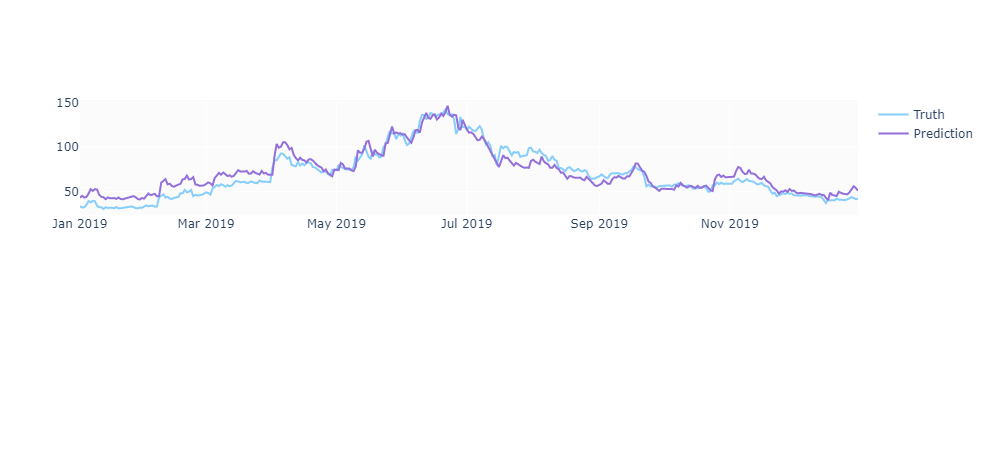

In [29]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df_test_2019.index, y=df_test_2019['Close'],
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_test_2019.index,
                         y=df_test_2019['Predicted Close'],
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.show()

#################

In [30]:
df_train_2021 = ltc_df.loc['2019-01-01':'2020-12-31', :]
df_train_2021.tail()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-12-27  129.456619  138.319717  123.097404  130.050339  127.516968   
2020-12-28  127.588303  136.185074  127.071342  129.040802  130.050339   
2020-12-29  130.033264  130.608582  121.187202  129.466080  129.040802   
2020-12-30  129.061859  132.450119  123.444344  124.690323  129.466080   
2020-12-31  129.480286  130.166245  123.036484  126.230347  124.690323   

                 Volume       SMA_5      SMA_10      SMA_15     SMA_30  \
Date                                                                     
2020-12-27  14103307412  119.468445  116.063739  106.676742  93.704789   
2020-12-28  10248729547  125.115100  118.130322  109.880055  95.616701   
2020-12-29   9160551332  128.610181  118.978512  112.991898  97.276892   
2020-12-30   8127317345  129.106677  120.458521  116.196258  98.673274   
2020-12-31   6274573135  128.152902  122.427013  118.322967  99.981759   

                 EMA_9        RSI       MACD  MACD Signal  
Date                                                       
2020-12-27  116.231097  67.062063  12.095096     9.460961  
2020-12-28  118.994945  68.054816  12.603991    10.089567  
2020-12-29  121.004117  67.185795  12.778530    10.627360  
2020-12-30  122.696509  67.374794  12.803578    11.062603  
2020-12-31  123.095272  62.987405  12.296320    11.309347

In [31]:
df_test_2021 = ltc_df.loc['2021-01-01':'2021-09-06', :]
df_test_2021.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-01-01  124.672768  133.185760  123.328079  136.944885  126.230347   
2021-01-02  126.272964  140.372574  123.693619  160.190582  136.944885   
2021-01-03  136.949402  163.898636  135.739914  154.807327  160.190582   
2021-01-04  160.271164  173.027817  143.623962  158.594772  154.807327   
2021-01-05  154.897552  162.850189  147.400070  169.016922  158.594772   

                 Volume       SMA_5      SMA_10      SMA_15      SMA_30  \
Date                                                                      
2021-01-01   7326980728  127.895578  123.682011  120.007685  101.227554   
2021-01-02  10532067985  129.274487  127.194794  121.845044  102.822417   
2021-01-03  15385661271  135.504443  132.057312  124.487156  105.494868   
2021-01-04  13659785704  140.572693  134.839685  127.163245  107.884488   
2021-01-05  10192818976  147.353583  137.753242  130.735870  110.385802   

                 EMA_9        RSI       MACD  MACD Signal  
Date                                                       
2021-01-01  123.722287  63.805900  11.881618    11.423801  
2021-01-02  126.366807  68.950507  12.276027    11.594246  
2021-01-03  133.131562  76.691310  14.299497    12.135296  
2021-01-04  137.466715  72.202115  15.292446    12.766726  
2021-01-05  141.692326  73.382635  16.198257    13.453032

In [32]:
x_train = df_train_2021.drop('Close', axis=1)
y_train = df_train_2021[['Close']]
x_test = df_test_2021.drop('Close', axis=1)
y_test = df_test_2021[['Close']]

In [33]:
# Preprocessing

scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [34]:
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [35]:
epochs = 50
batch_size = 10
model_1.fit(x_train, y_train, epochs=epochs, shuffle=False, batch_size=batch_size, verbose=1)

Epoch 1/50
73/73 [==============================] - 0s 7ms/step - loss: 0.0057
Epoch 2/50
73/73 [==============================] - 0s 7ms/step - loss: 0.0144
Epoch 3/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 4/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 5/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 6/50
73/73 [==============================] - 0s 7ms/step - loss: 0.0028
Epoch 7/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 8/50
73/73 [==============================] - 1s 7ms/step - loss: 0.0026
Epoch 9/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 10/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 11/50
73/73 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 12/50
73/73 [==============================] - 1s 7ms/step - loss: 0.0030
Epoch 13/50
73/73 [==============================

In [36]:
model_1.evaluate(x_test, y_test)

8/8 [==============================] - 0s 3ms/step - loss: 0.4612


0.46120601892471313

In [37]:
y_pred = model_1.predict(x_test)
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 0.46120599503505394


In [38]:
df_test_2021['Predicted Close'] = scaler.inverse_transform(y_pred.reshape(-1,1))

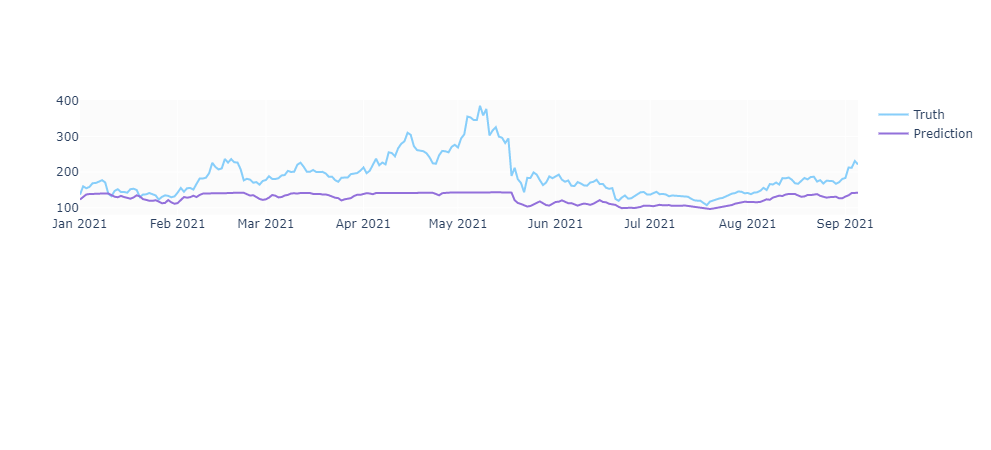

In [39]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df_test_2021.index, y=df_test_2021['Close'],
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_test_2021.index,
                         y=df_test_2021['Predicted Close'],
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.show()

In [40]:
df = pd.read_csv('LTC-USD_stock_prices.csv', index_col='Date', parse_dates=True)
get_moving_averages(df)
get_RSI(df)
get_MACD(df)
inp = df[-1:].drop('Close', axis=1)
inp

Open        High         Low   Adj Close      Volume  \
Date                                                                     
2021-09-06  230.913422  231.137619  216.673218  221.579605  3800275200   

                 SMA_5      SMA_10      SMA_15      SMA_30       EMA_9  \
Date                                                                     
2021-09-06  212.371054  193.206964  187.628407  180.782805  202.720623   

                  RSI       MACD  MACD Signal  
Date                                           
2021-09-06  69.095755  13.813123     9.377843

In [41]:
inp = np.array(inp)
inp = inp.reshape((inp.shape[0], inp.shape[1], 1))
tomorrow = model_1.predict(inp)
scaler.inverse_transform(tomorrow)

array([[137.35863]], dtype=float32)